In [1]:
#import scipy.stats as ss
import matplotlib.pyplot as plt
import cupy as cp
import cupy.random as cr
from tqdm import tqdm
import time

import numpy
import scipy.stats as ss

In [2]:


def vec_particle_gen(vp,nParticles):

    # Generate particles with maxwell distribution              
    # vp is the most probable speed of the maxwell distribution 

    
    velocity_vec = (vp/cp.sqrt(2))*cr.normal( size = (3,1,nParticles) )
    
    phase_vec = cr.uniform(  size = (1,1,nParticles) )*2*cp.pi
    
    amp_vec =  cr.normal( size = (3,1,nParticles) )
    
    normfac = 1/cp.sqrt(cp.sum(amp_vec[:,0,:]**2,axis=0))
    
    amp_vec[:,0,:] =  amp_vec[:,0,:]*cp.tile(normfac,(3,1))    

    
    return velocity_vec, amp_vec , phase_vec

def vector_random_walk(tX,omega,K,amp,phase):
    


    nParticles = omega.shape[2]
    nPoints = tX.shape[1]
    ret = cp.ndarray( (3,nPoints ) )
    
    phase_tensor = cp.tile(phase,(1,nPoints,1))
    amp_tensor = cp.tile(amp,(1,nPoints,1))
                     
    for i in [0,1,2]:          
        ret[i,:] = cp.sum( amp_tensor[i,:,:]*cp.sin(cp.outer(tX[0,:],omega[0,0,:]) 
                                  - cp.matmul(tX[1:,:].transpose(),K[:,0,:])
                                  + phase_tensor[:,0,:]), axis=1) 
    return ret




## Statistics.

In [3]:
'''
Get the marginal distribution
'''
vp=1e-3
log10m = -22
m=10**log10m

t_corr = 2*cp.pi/m
l_dB = 2*cp.pi/m/vp
#ev2kpc = 3.0857e19 /1.973e-7


nPoints = 16

tx = cp.zeros((4,nPoints))
tlist= cp.linspace(0,1,nPoints+1)
tx[0,:] = tlist[:-1]*t_corr

nParticles = 2**15 # gpu is generally faster than cpu when n is large
output=[]

nSimulation= 100000
Amps = cp.ndarray((3,nSimulation))
totAmps = cp.ndarray((1,nSimulation))
Phis = cp.ndarray((3,nSimulation))


'''
Main:
'''
for i in tqdm(range(nSimulation)):
    
    v,a,p=vec_particle_gen(vp,nParticles)
    
    # Physical values   
    m = 10**log10m # eV
    K = m*v

    # From K to omega
    omega = cp.ndarray((1,nPoints,nParticles))
    omega[0,:,:] = cp.sqrt(cp.sum(K*K,axis=0)+m**2)
    
    #Retx(3,nPoints)
    Ret = vector_random_walk(tx,omega,K,a,p)
    #results(3,nSimulation)
    
    Amps[:,i] = 2 * cp.sum(Ret*Ret,axis=1)/nPoints #  mean value over time
    totAmps[0,i] = 2 * cp.sum(cp.sum(Ret*Ret,axis=0))/nPoints
    Phis[0,i] = tlist[cp.where(cp.max(Ret[0]) == Ret[0])[0][0]]*2*cp.pi
    Phis[1,i] = tlist[cp.where(cp.max(Ret[1]) == Ret[1])[0][0]]*2*cp.pi
    Phis[2,i] = tlist[cp.where(cp.max(Ret[2]) == Ret[2])[0][0]]*2*cp.pi



100%|██████████| 100000/100000 [04:29<00:00, 370.59it/s]


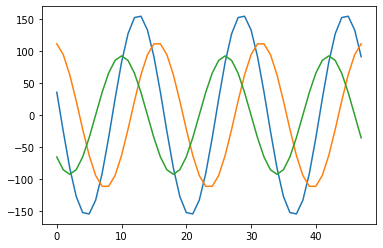

In [4]:
plt.plot(cp.asnumpy(cp.tile(Ret[0,:],3)))
plt.plot(cp.asnumpy(cp.tile(Ret[1,:],3)))
plt.plot(cp.asnumpy(cp.tile(Ret[2,:],3)))

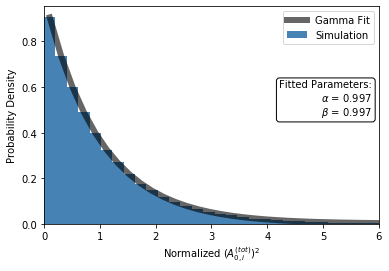

In [28]:
# Data processing
# Fit with gamma functions
y=Amps[2,:]
z=totAmps[0,:]
y=y/cp.mean(y)
#y=y/cp.mean(y)
y=cp.asnumpy(y)


plt.figure(figsize=(6,4))
# Histogram
Pr,bins,fig=plt.hist(y,60,density=True,label="Simulation",color="steelblue");
midbins = numpy.diff(bins)/2.+bins[:-1]

# curve fit
a,loc,scale = ss.gamma.fit(y,floc=0)
Pr_fit = ss.gamma.pdf(x=midbins,a=a,loc=loc,scale=scale)

plt.plot(midbins,Pr_fit,'black',linewidth=6,alpha=0.6,label='Gamma Fit')
plt.annotate(s="Fitted Parameters:"+"\n" + r"$\alpha$ = %.3f"%(a) + "\n" + r"$\beta$ = %.3f"%(1/scale),
             horizontalalignment="right",
         bbox=dict(boxstyle="round",fc="w"),xy=(0.98,0.5),xycoords='axes fraction',size=10)
plt.xlim([0,6])
plt.xlabel("Normalized $(A_{0,i}^{(tot)})^2$")
plt.ylabel("Probability Density")
plt.legend()
#plt.savefig('GammaFit.pdf')

# Comparing different models (independent)
# Assuming sqrt(A0x**2 + A0y**2 + A0z**2 ) = 1

In [27]:
size1 = 2**18
size2 = 26
omegat = cr.uniform(size=(size1,size2))*2*cp.pi
omegat_e = cr.uniform(size=(size1,1))*2*cp.pi
omegat_e = cp.tile(omegat_e,(1,size2))


ra_p = cr.uniform(size=(size1,size2))*2*cp.pi
sin_dec_p = cr.uniform(size=(size1,size2))*2-1
dec_p = cp.arcsin(sin_dec_p)
n_p = cp.array([cp.cos(dec_p)*cp.cos(ra_p),cp.cos(dec_p)*cp.sin(ra_p),cp.sin(dec_p)])
phase_p = cr.uniform(size=(size1,size2))*2*cp.pi

ra_e = cr.uniform(size=(size1,1))*2*cp.pi
sin_dec_e = cr.uniform(size=(size1,1))*2-1
dec_e = cp.arcsin(sin_dec_e)
n_e = cp.array([cp.cos(dec_e)*cp.cos(ra_e),cp.cos(dec_e)*cp.sin(ra_e),cp.sin(dec_e)])
n_e = cp.tile(n_e,(1,1,size2))

phase_e = cr.uniform(size=(size1,1))*2*cp.pi
phase_e = cp.tile(phase_e,(1,size2))

ra_pos = cr.uniform(size=(1,size2))*2*cp.pi
sin_dec_pos = cr.uniform(size=(1,size2))*2-1
dec_pos = cp.arcsin(sin_dec_pos)
n_pos = cp.array([cp.cos(dec_pos)*cp.cos(ra_pos),cp.cos(dec_pos)*cp.sin(ra_pos),cp.sin(dec_pos)])
n_pos = cp.tile(n_pos,(1,size1,1))

# old model (uncorr)

dt_B_uncorr = cp.sum(n_p*n_pos,axis=0)*cp.exp((omegat + phase_p)*1j) \
- cp.sum(n_e*n_pos,axis=0)*cp.exp((omegat_e + phase_e)*1j)     
dt_B_uncorr = cp.real(dt_B_uncorr)


dt_BL_uncorr = cp.sum(n_p*n_pos,axis=0)*cp.exp((omegat + phase_p)*1j) \
- 0.5*cp.sum(n_e*n_pos,axis=0)*cp.exp((omegat_e + phase_e)*1j)
dt_BL_uncorr=cp.real(dt_BL_uncorr)


# old model (corr)

dt_B_corr = cp.sum(n_e*n_pos,axis=0)*cp.exp((omegat + phase_p)*1j) \
- cp.sum(n_e*n_pos,axis=0)*cp.exp((omegat_e + phase_e)*1j)
dt_B_corr = cp.real(dt_B_corr)

dt_BL_corr = cp.sum(n_e*n_pos,axis=0)*cp.exp((omegat + phase_p)*1j) \
- 0.5*cp.sum(n_e*n_pos,axis=0)*cp.exp((omegat_e + phase_e)*1j)
dt_BL_corr = cp.real(dt_BL_corr)

# new model (uncorr)

normAp = cp.sqrt(cr.gamma(1,1,(size1,size2)))/cp.sqrt(3)

normAe = cp.sqrt(cr.gamma(1,1,(3,size1,1)))/cp.sqrt(3)


normAe = cp.tile(normAe,(1,1,size2))

phase_e_vec = cr.uniform(size=(3,size1,1))*2*cp.pi
phase_e_vec = cp.tile(phase_e_vec,(1,1,size2))


Dt_B_uncorr = normAp*cp.exp((omegat + phase_p)*1j) - cp.sum(normAe*n_pos*cp.exp((omegat_e + phase_e)*1j),axis=0)
Dt_B_uncorr = cp.real(Dt_B_uncorr)

Dt_BL_uncorr =  normAp*cp.exp((omegat + phase_p)*1j) - 0.5* cp.sum(normAe*n_pos*cp.exp((omegat_e + phase_e)*1j),axis=0)
Dt_BL_uncorr = cp.real(Dt_BL_uncorr)

# new model (corr)


Dt_B_corr = cp.sum(normAe*n_pos*cp.exp((omegat_e + phase_e + phase_p)*1j),axis=0)\
- cp.sum(normAe*n_pos*cp.exp((omegat_e + phase_e)*1j),axis=0)
Dt_B_corr = cp.real(Dt_B_corr)

Dt_BL_corr = cp.sum(normAe*n_pos*cp.exp((omegat_e + phase_e + phase_p)*1j),axis=0)\
- 0.5*cp.sum(normAe*n_pos*cp.exp((omegat_e + phase_e)*1j),axis=0)
Dt_BL_corr = cp.real(Dt_BL_corr)

#scalar#
#dt_scalar = cp.exp((omegat + phase_p)*1j) \
#- cp.exp((omegat_e + phase_e)*1j)

dt_scalar = cp.sin((phase_p-phase_e))*cp.sin((2*omegat + phase_e + phase_p)) \

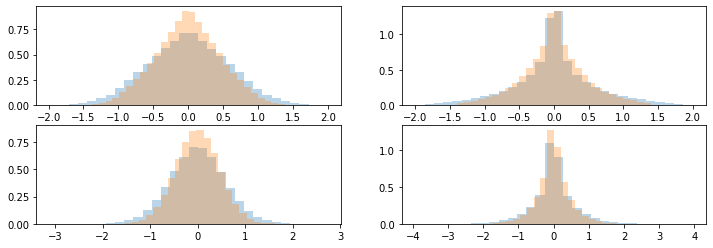

In [3]:
fig,((ax1,ax2),(ax3,ax4))=plt.subplots(2,2,figsize=(12,4))


ax1.hist(cp.asnumpy(cp.hstack(dt_B_uncorr)),30,density=True,alpha=0.3);
ax1.hist(cp.asnumpy(cp.hstack(dt_BL_uncorr)),30,density=True,alpha=0.3);

ax2.hist(cp.asnumpy(cp.hstack(dt_B_corr)),30,density=True,alpha=0.3);
ax2.hist(cp.asnumpy(cp.hstack(dt_BL_corr)),30,density=True,alpha=0.3);

ax3.hist(cp.asnumpy(cp.hstack(Dt_B_uncorr)),30,density=True,alpha=0.3);
ax3.hist(cp.asnumpy(cp.hstack(Dt_BL_uncorr)),30,density=True,alpha=0.3);

ax4.hist(cp.asnumpy(cp.hstack(Dt_B_corr)),30,density=True,alpha=0.3);
ax4.hist(cp.asnumpy(cp.hstack(Dt_BL_corr)),30,density=True,alpha=0.3);

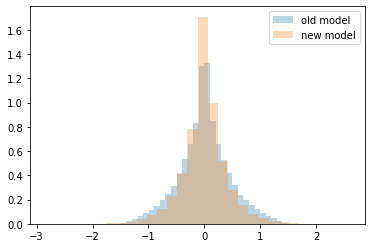

In [90]:
plt.hist(cp.asnumpy(cp.hstack(dt_BL_corr)),30,density=True,alpha=0.3,label="old model");
plt.hist(cp.asnumpy(cp.hstack(Dt_BL_corr)),30,density=True,alpha=0.3,label="new model");
plt.legend()
plt.savefig('delta_t.pdf')

In [28]:

cp.sqrt(cp.mean(dt_scalar**2))

array(0.50013354)

In [ ]:
# Check the linear combination of A_i
# Ak=np.sqrt((Ax**2+Ay**2+2*Ax*Ay*np.sin(Phix+Phiy))/2.)


## Check the space coherence


In [91]:

vp=1e-3
log10m = -22
m=10**log10m

t_corr = 2*cp.pi/m
l_dB = 2*cp.pi/m/vp
#ev2kpc = 3.0857e19 /1.973e-7


nPoints = 16

tx = cp.zeros((4,nPoints))
tlist= cp.linspace(0,1,nPoints+1)
tx[0,:] = tlist[:-1]*t_corr

ty = cp.zeros((4,nPoints))
ty[0,:] = tlist[:-1]*t_corr
ty[1,:] = cp.tile(l_dB,nPoints)*20.48

nParticles = 2**10
output=[]

nSimulation= 100000
Amps_x = cp.ndarray((3,nSimulation))
Phis_x = cp.ndarray((3,nSimulation))
Amps_y = cp.ndarray((3,nSimulation))
Phis_y = cp.ndarray((3,nSimulation))

'''
Main:
'''
for i in tqdm(range(nSimulation)):
    v,a,p=vec_particle_gen(vp,nParticles)

    # Physical values   
    m = 10**log10m # eV
    K = m*v

    # From K to omega
    omega = cp.ndarray((1,1,nParticles))
    omega[0,:,:] = cp.sqrt(cp.sum(K*K,axis=0)+m**2)

    #Retx(3,nPoints)

    Ret_x = vector_random_walk(tx,omega,K,a,p)
    Ret_y = vector_random_walk(ty,omega,K,a,p)
    
    #results(3,nSimulation)
    Amps_x[:,i] = 2 * cp.sum(Ret_x*Ret_x,axis=1)/nPoints #  mean value over time
    Phis_x[0,i] = tlist[cp.where(cp.max(Ret_x[0]) == Ret_x[0])[0][0]]*2*cp.pi
    Phis_x[1,i] = tlist[cp.where(cp.max(Ret_x[1]) == Ret_x[1])[0][0]]*2*cp.pi
    Phis_x[2,i] = tlist[cp.where(cp.max(Ret_x[2]) == Ret_x[2])[0][0]]*2*cp.pi
    
    Amps_y[:,i] = 2 * cp.sum(Ret_y*Ret_y,axis=1)/nPoints #  mean value over time
    Phis_y[0,i] = tlist[cp.where(cp.max(Ret_y[0]) == Ret_y[0])[0][0]]*2*cp.pi
    Phis_y[1,i] = tlist[cp.where(cp.max(Ret_y[1]) == Ret_y[1])[0][0]]*2*cp.pi
    Phis_y[2,i] = tlist[cp.where(cp.max(Ret_y[2]) == Ret_y[2])[0][0]]*2*cp.pi


100%|██████████| 100000/100000 [04:55<00:00, 338.88it/s]


In [95]:
'''
Calculate the correlation !!!
'''

a = Amps_x[0,:]
b = Amps_y[0,:]
c = Amps_y[1,:]
d = Phis_x[0,:]
e = Phis_y[0,:]
f = Phis_y[1,:]
results=[]
for (x2,y2) in [(a,b),(a,c),(d,e),(d,f),(a,e),(a,f)]:

    x = cp.sqrt(x2)
    y = cp.sqrt(y2)

    m_x2 = cp.mean(x2)
    m_x = cp.mean(x)
    m_y2 = cp.mean(y2)
    m_y = cp.mean(y)

    sig_x = cp.sqrt(m_x2-m_x**2)
    sig_y = cp.sqrt(m_y2-m_y**2)

    results.append(cp.mean((x-m_x)*(y-m_y))/sig_x/sig_y)

print(results)

[array(-0.00434179), array(-0.00549679), array(-0.00084351), array(-0.00133677), array(0.00223206), array(-0.00334016)]


In [85]:
kpc2nat = 3.0857e19 /1.973e-7

l = 2*kpc2nat/(2*cp.pi/10**(-21)/vp)
print("%.3f"%(l))

49.783


In [99]:
corr = cp.ndarray((14,6))
Dis = cp.array([0.0025,0.005,0.01,0.02,0.04,0.08,0.16,0.32,0.64,1.28,2.56,5.12,10.24,20.48])
corr[0,:] = cp.array([0.99985708, 0.00150044, 0.98716283, 0.00250952, -0.00217314, 0.00219149])
corr[1,:] = cp.array([0.99941614,-0.00594856,0.97544193,0.00071943,-0.00329441,0.00215547])
corr[2,:] = cp.array([0.9976607022205033, 0.0037676705818899463, 0.9327020080089024, 0.007450448389243849, -0.009171508248407718, 0.005356242440316161])
corr[3,:] = cp.array([0.99106258203287, 0.011099269792954449, 0.9012317040062288, 0.004039380559944105, -0.0034537435583275934, 0.004679418272634157])
corr[4,:] = cp.array([0.9643100923845139, -0.000992748126691237, 0.7965985256746666, -0.01105591066757477, 0.00970309745521556, 0.009073964597856511])
corr[5,:] = cp.array([0.8623397830753567, 0.007114731531677067, 0.6580210721689032, 0.006986199182822402, -0.001957350351134233, 0.013300395224419708])
corr[6,:] = cp.array([0.5721820929063567, -0.007412828990754051, 0.43119528453945477, -0.0036480322991355608, 0.005106476076536831, -0.003291443323211755])
corr[7,:] = cp.array([0.11629739390099995, 0.0059398877230059325, 0.17160920059913792, -0.007730739043007247, -0.015587786942008451, 0.004431751607055087])
corr[8,:] = cp.array([0.0004846887852723556, 0.00923196440467667, 0.008129350252005289, 0.002672610405310479, -0.014295219328776707, 0.014190959985873657])
corr[9,:] = cp.array([0.007517423340686037, 0.020655454466178978, -0.0008678267229125785, 0.005190865100771142, -0.018050857571350856, 0.004259351720611055])
corr[10,:] = cp.array([-0.009911551109561472, 0.019040773634095867, -0.004305765239621097, -0.008191116532864086, 0.00571505800291175, -0.021481308743130006])
corr[11,:] = cp.array([0.00997750749582416, 0.012745851516836933, -0.008872693213043598, 0.0048421096593427556, 0.00752769696005557, 0.0009189869377229605])
corr[12,:] = cp.array([5.5234968e-05, -0.00180336, -0.00058524, 0.00084423, 0.00324677, -0.00295892])
corr[13,:] = cp.array([-0.00434179, -0.00549679, -0.00084351, -0.00133677, 0.00223206, -0.00334016])


perc235 = cp.array([0.008,0.157])
perc23  = cp.array([0.025,0.498])

perc225 = cp.array([0.079,1.574])
perc22  = cp.array([0.249,4.978])
perc215 = cp.array([0.787,15.743])
perc21 = cp.array([2.489,49.783])



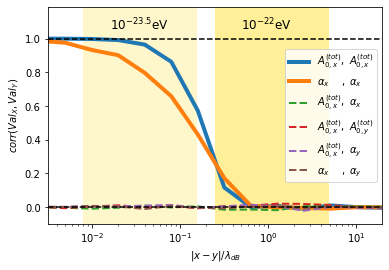

In [146]:
corr = cp.asnumpy(corr)
Dis = cp.asnumpy(Dis)
perc235 = cp.asnumpy(perc235)
perc23 = cp.asnumpy(perc23)
perc225 = cp.asnumpy(perc225)
perc22 = cp.asnumpy(perc22)
perc215 = cp.asnumpy(perc215)
perc21 = cp.asnumpy(perc21)

plt.figure(figsize=(6,4))
ll = -0.1
hl = 1.19
lel = 10**-2.5
ril = 10**1.3
plt.ylim([ll,hl])
plt.xlim([lel,ril])

plt.semilogx(Dis,corr[:,0],label=r"$A_{0,x}^{(tot)},\ A_{0,x}^{(tot)}$",linewidth=4);
plt.semilogx(Dis,corr[:,2],label=r"$\alpha_{x}\ \ \ \ ,\ \alpha_{x}$",linewidth=4);
plt.semilogx(Dis,corr[:,4],'--',label=r"$A_{0,x}^{(tot)},\ \alpha_{x}$",linewidth=2);
plt.semilogx(Dis,corr[:,1],'--',label=r"$A_{0,x}^{(tot)},\ A_{0,y}^{(tot)}$",linewidth=2);
plt.semilogx(Dis,corr[:,5],'--',label=r"$A_{0,x}^{(tot)},\ \alpha_{y}$",linewidth=2);
plt.semilogx(Dis,corr[:,3],'--',label=r"$\alpha_{x}\ \ \ \ ,\ \alpha_{y}$",linewidth=2);

plt.plot([lel,ril],[0,0],'k--')
plt.plot([lel,ril],[1,1],'k--')

plt.fill_between(perc235,[hl,hl],[ll,ll],facecolor='gold',alpha=0.2)
plt.fill_between(perc22,[hl,hl],[ll,ll],facecolor='gold',alpha=0.4)

plt.annotate("$10^{-23.5}$eV",horizontalalignment="left",xy=[perc235[0]*2,1.05],xycoords='data',size=12)
plt.annotate("$10^{-22}$eV",horizontalalignment="left",xy=[perc22[0]*2,1.05],xycoords='data',size=12)



plt.xlabel("$|x-y|/\lambda_{dB}$")
plt.ylabel("$corr(Val_{X},Val_{Y})$")
plt.legend()
plt.savefig('SpatialCorr.pdf')

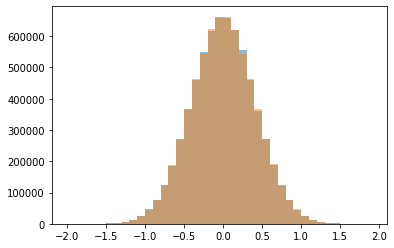

In [135]:
"""
size1=2**18

#normAe = cr.gamma(3.138,1./3.540,(3,size1,1))/cp.sqrt(3)

normAe = cp.sqrt(cr.gamma(1,1,(3,size1,1)))/cp.sqrt(3)

normAe = cp.tile(normAe,(1,1,size2))

phase_e_vec = cr.uniform(size=(3,size1,1))*2*cp.pi
phase_e_vec = cp.tile(phase_e_vec,(1,1,size2))



an=(normAe[0,:,:]*cp.exp(phase_e_vec[0,:,:]*1j)+normAe[1,:,:]*cp.exp(phase_e_vec[1,:,:]*1j))/cp.sqrt(2)
an=cp.real(cp.hstack(an))

bn=normAe[0,:,:]*cp.exp(phase_e_vec[0,:,:]*1j)
bn=cp.real(cp.hstack(bn))

bins=cp.asnumpy(cp.arange(-2,2,0.1))

plt.hist(cp.asnumpy(an),alpha=0.5,bins=bins);
plt.hist(cp.asnumpy(bn),alpha=0.5,bins=bins);
"""